In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits.basemap import Basemap, cm
import gsw as sw
import scipy.stats as ss
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

from scipy.cluster.hierarchy import fcluster

from netCDF4 import Dataset

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

In [2]:
in_file = '../data/KuroAlldata.csv'
data = pd.read_csv(in_file, sep = ',').dropna(axis=0, subset=['depth (m)'])

data['theta'] = sw.conversions.pt_from_t(data['S'], data['T(C)'], data['depth (m)'])

data['transect'] = 0
data.loc[(data['station']<9),'transect'] = 'A'
data.loc[((data['station']>8) & (data['station']<17)),'transect'] = 'B'
data.loc[((data['station']>16) & (data['station']<26)),'transect'] = 'C'
data.loc[((data['station']>25) & (data['station']<34)),'transect'] = 'D'
data.loc[(data['station']>33),'transect'] = 'E'

data = data[data['station']!= 41]

data['station'] = data['transect'] + data['station'].astype(str) 
data['sample'] = data['station'] + '-' + data['depth (m)'].astype(int).astype(str)
data.set_index('sample', inplace = True)

# import and merge phytoplankton counts
in_file = '../data/Kuroshio_Phytoplankton.xlsx'
phyto = pd.read_excel(in_file, sheet_name = 'PFTs')
phyto = phyto[phyto['STATION']!='E41']

phyto['sample'] = phyto["STATION"] + '-' + phyto["depth"].astype(int).astype(str)
phyto = phyto[phyto['sample']!='D31-90']
phyto.set_index('sample', inplace = True)

# phyto = phyto[phyto['depth']<60]

data = data.loc[phyto.index, :]

print phyto.columns

/Users/sclayton/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:809: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/Users/sclayton/anaconda/lib/python2.7/site-packages/gsw-3.0.3-py2.7.egg/gsw/utilities/utilities.py:251: RuntimeWarning: invalid value encountered in less
  SA[SA < 0] = np.ma.masked
/Users/sclayton/anaconda/lib/python2.7/site-packages/gsw-3.0.3-py2.7.egg/gsw/gibbs/library.py:899: RuntimeWarning: invalid value encountered in greater
  nonzero_SA = np.any(SA > 0)
/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


Index([u'STATION', u'BOTTLE', u'depth', u'latitude', u'longitude',
       u'Oscillatoriaceae', u'Cryptophytes', u'Haptophytes', u'Euglenophytes',
       u'Prasinophytes', u'Diatoms', u'Dinoflagellates'],
      dtype='object')


/Users/sclayton/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [3]:
## need to integrate envorinmental data here
from skbio.diversity.beta import pw_distances

# subset
sub = phyto[['Oscillatoriaceae', u'Cryptophytes', u'Haptophytes', u'Euglenophytes',
       u'Prasinophytes', u'Diatoms', u'Dinoflagellates']]
# print sub.columns

# or exclude everything but dinos and diatoms
ids = sub.columns
counts = sub.iloc[0:, 2:-4]
stations = sub.index
# print ids
bc_dm = pw_distances(counts, stations, metric = "braycurtis")

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(280.164,0.5,u'Station')

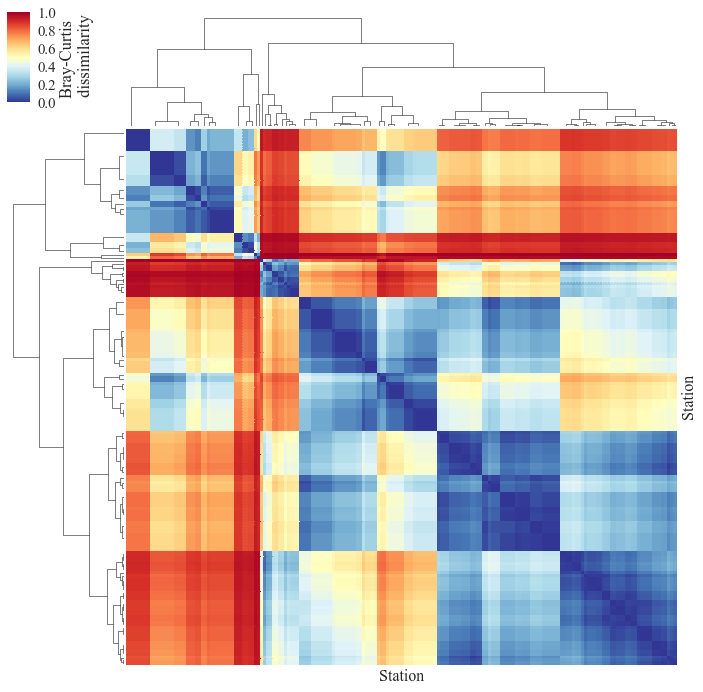

In [4]:
sns.set(font_scale=1.5)
sns.set_style("white",{'font.family': 'Times New Roman'},)

link = hierarchy.linkage(bc_dm.condensed_form(), method='average')

cm = sns.clustermap(bc_dm.data, standard_scale=1, row_linkage = link, col_linkage = link, cmap = 'RdYlBu_r',figsize=(12,12), cbar_kws={'label':'Bray-Curtis \n dissimilarity'})
ax = cm.ax_heatmap
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Station', fontsize = 16)
ax.set_ylabel('Station', fontsize = 16)

# cm.savefig('../figures/Figure3.png',dpi = 300)

/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'ew'
  s)


1
2
3
4
5


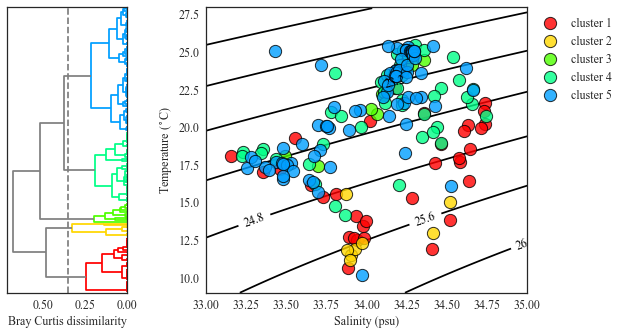

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     184
number of groups                  5
test statistic              369.511
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


In [5]:
# Z = hierarchy.linkage(1 - bc_dm.data, 'ward')
# palette = ['red','orange', 'blue', 'lightblue']

crit_dist = 0.35

from scipy.cluster.hierarchy import fcluster
max_d = crit_dist

clusters = fcluster(link, max_d, criterion='distance')
temp = data[['station','depth (m)','S','theta']]
temp['cluster'] = clusters


palette = plt.get_cmap('hsv', np.max(clusters)+3)
colours = ['#%02x%02x%02x' % tuple(col * 255 for col in palette(i)[:3])
          for i in range(palette.N)]

from matplotlib import gridspec

fig1 = plt.figure(figsize=(8,5), dpi = 300)
#set fontsize
nn = 12

gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 4]) 
ax1 = plt.subplot(gs[0])

# ax1.set_ylabel('Station - Depth',fontsize = nn)
ax1.set_xlabel('Bray Curtis dissimilarity',fontsize = nn)
 
ax1.yaxis.set_ticks_position("right") # ticks and ticklabels 
ax1.yaxis.set_label_position("right") # axis label 

hierarchy.set_link_color_palette(colours)
# hierarchy.set_link_color_palette(palette)
dend = hierarchy.dendrogram(
    link,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=bc_dm.ids,
    orientation="left", 
    color_threshold = crit_dist, 
    above_threshold_color='grey'
)
ax1.axvline(crit_dist, linestyle = '--', color = 'grey')
# ax1.set_xlim([0, 1])

ax1.set_yticklabels([])
ax2 = plt.subplot(gs[1])

# print np.max(clusters)

SS = np.arange(30,36,0.1)
TT = np.arange(9, 28, 0.1)

ss, tt = np.meshgrid(SS, TT, indexing='ij')

den = sw.density_enthalpy_48.sigma0(ss, tt)

ax2.set_xlim([33, 35])
ax2.set_ylim([9, 28])

cs = ax2.contour(ss, tt, den, [21.6, 22.4, 23.2, 24.0, 24.8, 25.6, 26.4], zorder = 0, colors = 'k', ew = 1)
ax2.clabel(cs, inline=1, fontsize=nn, fmt='%3.1f')

i = 0
cc = colours
for c in range(1,np.max(clusters)+1):
    print c
    lab = 'cluster %d' %c
    ctemp = temp[temp['cluster'] == c]
    cb = ax2.scatter(ctemp['S'].values, ctemp['theta'].values, s = 150,c= cc[i], marker = 'o',lw = 1, alpha = 0.8, edgecolor = 'k', label = lab)
    i += 1
ax2.set_xlabel('Salinity (psu)', fontsize = nn)
ax2.set_ylabel(r'Temperature ($^{\circ}$C)', fontsize = nn)

ax2.tick_params(axis='both', which='major', labelsize = nn)
ax2.tick_params(axis='both', which='minor', labelsize = nn)

ax1.tick_params(axis='both', which='major', labelsize = nn)
ax1.tick_params(axis='both', which='minor', labelsize = nn)

ax2.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize = 12)

plt.show()
fig1.savefig('../figures/Figure4.png',dpi = 300, bbox_inches='tight')

from skbio.stats.distance import permanova
print permanova(bc_dm, clusters, column=None, permutations=999)

In [6]:
for n in pd.unique(clusters):
    print n, len(temp[temp['cluster']==n])


4 46
5 80
1 36
2 9
3 13


In [7]:
from skbio.stats.ordination import RDA
phyto['cluster'] = clusters
sub['cluster'] = clusters
# X = data[['depth (m)','S', 'sigma_t', 'theta', 'SiO2 (uM)', 'NO3 (uM)','NH4(uM)','PO4 (uM)']].dropna()
X = data[['depth (m)','S', 'theta', 'NO3 (uM)' ]].dropna()#, 'SiO2 (uM)', 'NO3 (uM)']].dropna()

phyto = phyto.loc[X.index, :]
Y = phyto.iloc[:, 2:-1]

print len(Y), len(X.index)
e_vars = X.columns
thing = RDA(Y, X, stations, e_vars, scale_Y=True).scores(1)

print thing
print np.max((thing.proportion_explained)*100)


182 182
Ordination results:
	Eigvals: 13
	Proportion explained: 13
	Species: 10x13
	Site: 182x13
	Biplot: 4x4
	Site constraints: 182x13
	Species IDs: 'depth (m)', 'S', 'theta', 'NO3 (uM)'
	Site IDs: u'A1-0', u'A1-25', u'A1-48', u'A1-75', u'A1-150', u'A2-0', u'A2-25', u'A2-50', ...
12.1784940876


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [8]:

for n in range(1,np.max(clusters+1)):
    print 'dominant phyto in cluster ', n
    
    tmp = Y[phyto['cluster']==n].sum()
    print 'number of samples in cluster', len(Y[phyto['cluster']==n])
#     print 'stations in cluster', n, phyto.loc[(phyto['cluster']==n), 'STATION']
    print tmp.sort_values(axis=0, ascending=False)[0:5]/np.sum(tmp)*100
    print " "
    print "--- environment ---"
    print X[phyto['cluster']==n].describe()
    print '--------' '\n' '--------' '\n'

dominant phyto in cluster  1
number of samples in cluster 36
Haptophytes         42.391357
Dinoflagellates     23.151492
Diatoms             15.092768
Cryptophytes         7.150168
Oscillatoriaceae     5.483588
dtype: float64
 
--- environment ---
        depth (m)          S      theta   NO3 (uM)
count   36.000000  36.000000  36.000000  36.000000
mean    69.166667  34.172714  17.445136   5.196626
std     38.794329   0.429949   3.730857   3.283159
min      0.000000  33.156000  10.620972   0.028571
25%     47.500000  33.914500  14.026746   3.143571
50%     72.500000  34.214750  17.639952   4.757707
75%     90.000000  34.578625  20.133930   7.121881
max    155.000000  34.741000  25.071600  11.870000
--------
--------

dominant phyto in cluster  2
number of samples in cluster 8
Diatoms            27.211247
Dinoflagellates    26.471409
Haptophytes        22.209941
Cryptophytes       15.359040
longitude           4.278114
dtype: float64
 
--- environment ---
        depth (m)          S    

In [9]:

for n in range(1,np.max(clusters+1)):
    print 'cluster', n
    
    tmp = Y[phyto['cluster']==n]
    tmp['richness'] = tmp.astype(bool).sum(axis=1)
    
    print tmp['richness'].mean(), '+/-', tmp['richness'].std()
                   


cluster 1
6.16666666667 +/- 0.845154254729
cluster 2
6.25 +/- 1.03509833901
cluster 3
6.53846153846 +/- 0.660225291774
cluster 4
6.08695652174 +/- 0.783895881877
cluster 5
6.27848101266 +/- 0.846360365462


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7
  Oscillatoriaceae Cryptophytes Haptophytes Euglenophytes Prasinophytes  \
1        0.0576174    0.0751285    0.445416             0     0.0199966   
2                0     0.151932    0.246048    0.00658665             0   
3        0.0239623    0.0193631    0.799335   0.000386488    0.00510165   
4       0.00626622    0.0508151    0.652861    0.00220297     0.0127772   
5        0.0260574    0.0311664    0.740266   0.000711561       0.01083   

     Diatoms Dinoflagellates  
1   0.158583        0.243258  
2   0.333577        0.261856  
3  0.0657417       0.0861096  
4   0.129437        0.145641  
5  0.0805203        0.110449  


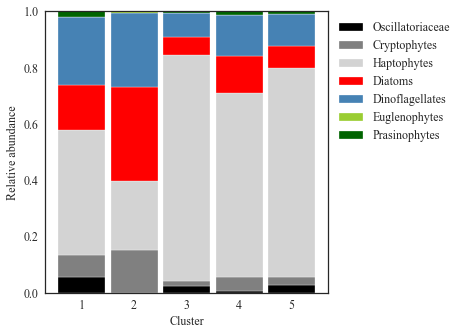

In [10]:
fig2 = plt.figure(figsize=(5,5), dpi = 300)


print len(ids)
step = 1.2
barwidth = 0.25
rank_clusters = pd.DataFrame()

bcols = colours
pclu = sub.groupby('cluster').sum()
pclu['tot'] = pclu.sum(axis=1)

ptot = pd.DataFrame(columns = ['Oscillatoriaceae', u'Cryptophytes', u'Haptophytes', u'Euglenophytes', u'Prasinophytes', u'Diatoms', u'Dinoflagellates'])

for n in range(1,np.max(clusters+1)):
    vv = np.float(pclu.loc[n, ['tot']])
#     print vv
    ptot.loc[n,] = pclu.loc[n, ['Oscillatoriaceae', u'Cryptophytes', u'Haptophytes', u'Euglenophytes', u'Prasinophytes', u'Diatoms', u'Dinoflagellates']]/vv
print ptot

# plot
r = np.arange(0, np.max(clusters))

barWidth = 0.9

ax1 = fig2.add_subplot(111)
# Create green Bars
ax1.bar(r, ptot['Oscillatoriaceae'], color='k', edgecolor='white', width=barWidth, label = 'Oscillatoriaceae')
# Create orange Bars
ax1.bar(r, ptot['Cryptophytes'], bottom=ptot['Oscillatoriaceae'], color='grey', edgecolor='white', width=barWidth, label = 'Cryptophytes')
# Create blue Bars
ax1.bar(r, ptot['Haptophytes'], bottom=[i+j for i,j in zip(ptot['Oscillatoriaceae'], ptot['Cryptophytes'])], color='lightgrey', edgecolor='white', width=barWidth, label = 'Haptophytes')
# Create blue Bars
ax1.bar(r, ptot['Diatoms'], bottom=[i+j+k for i,j,k in zip(ptot['Oscillatoriaceae'], ptot['Cryptophytes'],ptot['Haptophytes'])], color='red', edgecolor='white', width=barWidth, label = 'Diatoms')
# Create blue Bars
ax1.bar(r, ptot['Dinoflagellates'], bottom=[i+j+k+l for i,j,k,l in zip(ptot['Oscillatoriaceae'], ptot['Cryptophytes'],ptot['Haptophytes'],ptot['Diatoms'])], color='steelblue', edgecolor='white', width=barWidth, label = 'Dinoflagellates')
# Create blue Bars
ax1.bar(r, ptot['Euglenophytes'], bottom=[i+j+k+l+m for i,j,k,l,m in zip(ptot['Oscillatoriaceae'], ptot['Cryptophytes'],ptot['Haptophytes'],ptot['Diatoms'],ptot['Dinoflagellates'])], color='yellowgreen', edgecolor='white', width=barWidth, label = 'Euglenophytes')
# Create blue Bars
ax1.bar(r, ptot['Prasinophytes'], bottom=[i+j+k+l+m+n for i,j,k,l,m,n in zip(ptot['Oscillatoriaceae'], ptot['Cryptophytes'],ptot['Haptophytes'],ptot['Diatoms'],ptot['Dinoflagellates'],ptot['Euglenophytes'])], color='darkgreen', edgecolor='white', width=barWidth, label = 'Prasinophytes') 
   
ax1.set_xticks(r)
ax1.set_xticklabels(['1','2','3','4','5'],fontsize = 12)
ax1.set_xlabel("Cluster", fontsize = 12)
ax1.set_ylabel('Relative abundance', fontsize = 12)
ax1.tick_params(labelsize = 12)

ax1.set_ylim([0,1])

ax1.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize = 12)
plt.show()
fig2.savefig('../figures/cluster_relabundance.png',dpi = 300, bbox_inches='tight')

In [11]:
pclu.to_csv('../data/phyto_byclusters.csv', sep = ',')